In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

history = pd.DataFrame()

for i in range(9):
    f = open('spotify_data/StreamingHistory{}.json'.format(i), encoding='utf-8')
    data = json.load(f)
    df = pd.DataFrame(data)
    history = pd.concat([history, df], ignore_index=True)

history = history.loc[history['trackName'] !="Unknown Track"]
history = history.loc[history['msPlayed'] >=20000]
history['minsPlayed'] = history['msPlayed']/(1000*60)

spring = history.loc[history['endTime']<'2022-05-11'].copy()
summer = history.loc[(history['endTime']>='2022-05-11') & (history['endTime']<'2022-08-28')].copy()
fall = history.loc[history['endTime']>='2022-08-28'].copy()


summer_home = history.loc[(history['endTime']>='2022-05-11') & (history['endTime']<'2022-06-02')].copy()
summer_sf = history.loc[(history['endTime']>='2022-06-02') & (history['endTime']<'2022-08-28')].copy()


spring['endTime']= pd.DatetimeIndex(spring['endTime']).tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)
summer_home['endTime'] = pd.DatetimeIndex(summer_home['endTime']).tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)
summer_sf['endTime']= pd.DatetimeIndex(summer_sf['endTime']).tz_localize('UTC').tz_convert('America/Los_Angeles').tz_localize(None)
fall['endTime']= pd.DatetimeIndex(fall['endTime']).tz_localize('UTC').tz_convert('America/New_York').tz_localize(None)
history = pd.concat([spring, summer_home, summer_sf, fall], ignore_index=True)

summer = pd.concat([summer_home, summer_sf], ignore_index=True)

history['date'] = pd.DatetimeIndex(history['endTime']).date
history

,endTime,artistName,trackName,msPlayed,minsPlayed,date
0,2021-12-31 19:03:00,Swedish House Mafia,Save The World,209705,3.495083,2021-12-31
1,2021-12-31 19:06:00,Sam Feldt,Post Malone (feat. RANI),169642,2.827367,2021-12-31
2,2021-12-31 19:09:00,Tiësto,Wasted,190013,3.166883,2021-12-31
3,2021-12-31 19:13:00,Lana Del Rey,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,214912,3.581867,2021-12-31
4,2021-12-31 19:17:00,Calvin Harris,This Is What You Came For,222160,3.702667,2021-12-31
...,...,...,...,...,...,...
67088,2023-01-01 18:28:00,Will Gittens,Vibin,47143,0.785717,2023-01-01
67089,2023-01-01 18:33:00,Dayglow,Can I Call You Tonight?,278769,4.646150,2023-01-01
67090,2023-01-01 18:36:00,ILLENIUM,First Time,165779,2.762983,2023-01-01
67091,2023-01-01 18:40:00,Martin Garrix,No Sleep (feat. Bonn) - DubVision Remix,239062,3.984367,2023-01-01


In [2]:
artist_totals = history.groupby(['artistName'])['minsPlayed'].sum().sort_values(ascending=False)
artist_counts = history.groupby(['artistName'], as_index=False).size().sort_values(by='size', ascending=False)

print('Number of unique artists:', len(artist_totals))

Number of unique artists: 4435


/Users/jyin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jyin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29246 (\N{CJK UNIFIED IDEOGRAPH-723E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jyin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23459 (\N{CJK UNIFIED IDEOGRAPH-5BA3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


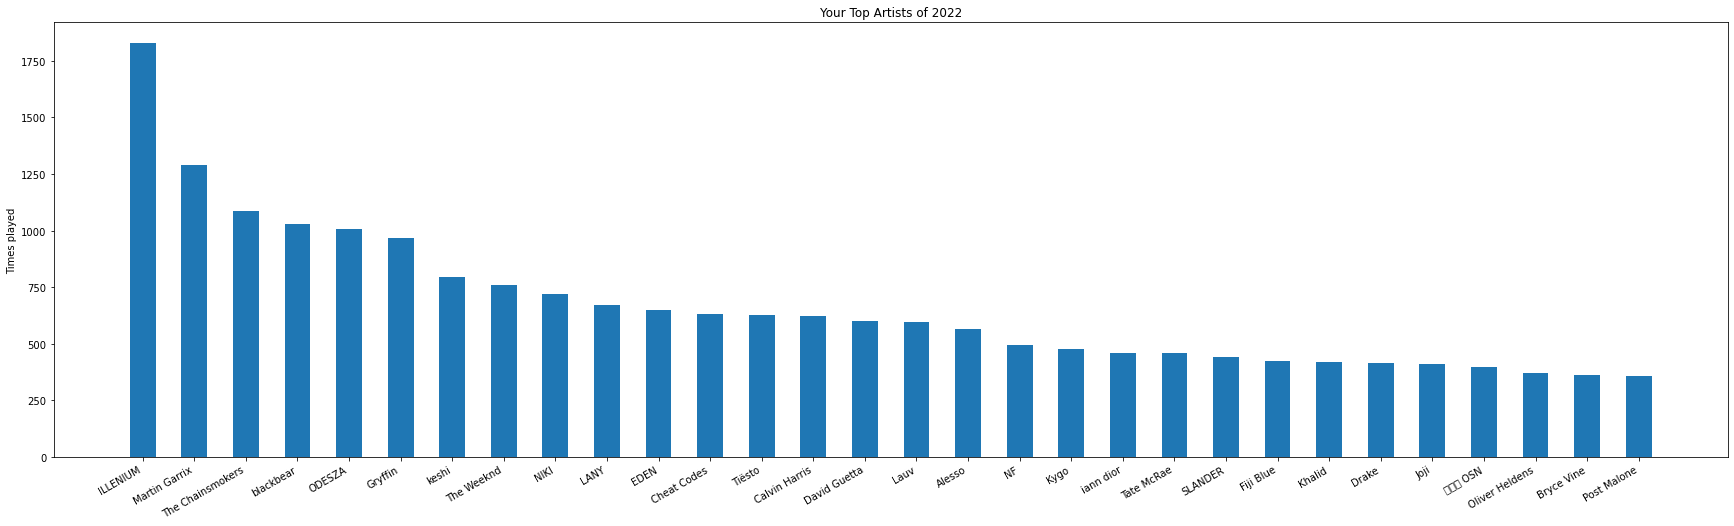

In [3]:
values = artist_counts['size'].values[:30]
labels = artist_counts['artistName'].values[:30]
indexes = np.arange(len(labels))

plt.figure(figsize=(30,8))
plt.title('Your Top Artists of 2022')
plt.bar(indexes, values, 0.5)
plt.xticks(indexes, labels, rotation = 30, ha='right')
plt.ylabel('Times played')
plt.show()

In [4]:
top_artists = artist_totals.index.values[:10]
# top_artists = artist_counts['artistName'].values[:10]


all_dates = history[['date']].drop_duplicates()
artist_daily_totals = history.groupby(['date', 'artistName'], as_index=False)['minsPlayed'].agg(sum)
top_artists_df = pd.DataFrame()
for artist in top_artists:
    artist_df = all_dates.merge(artist_daily_totals.loc[artist_daily_totals['artistName']==artist], how='left', on = ['date'])
    artist_df['artistName'].fillna(value=artist, inplace=True)
    artist_df['minsPlayed'].fillna(value=0, inplace=True)
    artist_df['avg_minsPlayed'] = artist_df['minsPlayed'].rolling(14, win_type='gaussian', center=True).mean(std=3)
    top_artists_df = pd.concat([top_artists_df, artist_df])
    
top_artists_df

,date,artistName,minsPlayed,avg_minsPlayed
0,2021-12-31,ILLENIUM,0.000000,NaN
1,2022-01-01,ILLENIUM,3.967733,NaN
2,2022-01-02,ILLENIUM,6.150817,NaN
3,2022-01-03,ILLENIUM,3.092383,NaN
4,2022-01-04,ILLENIUM,3.184833,NaN
...,...,...,...,...
362,2022-12-28,keshi,0.000000,NaN
363,2022-12-29,keshi,0.000000,NaN
364,2022-12-30,keshi,18.741200,NaN
365,2022-12-31,keshi,5.591500,NaN


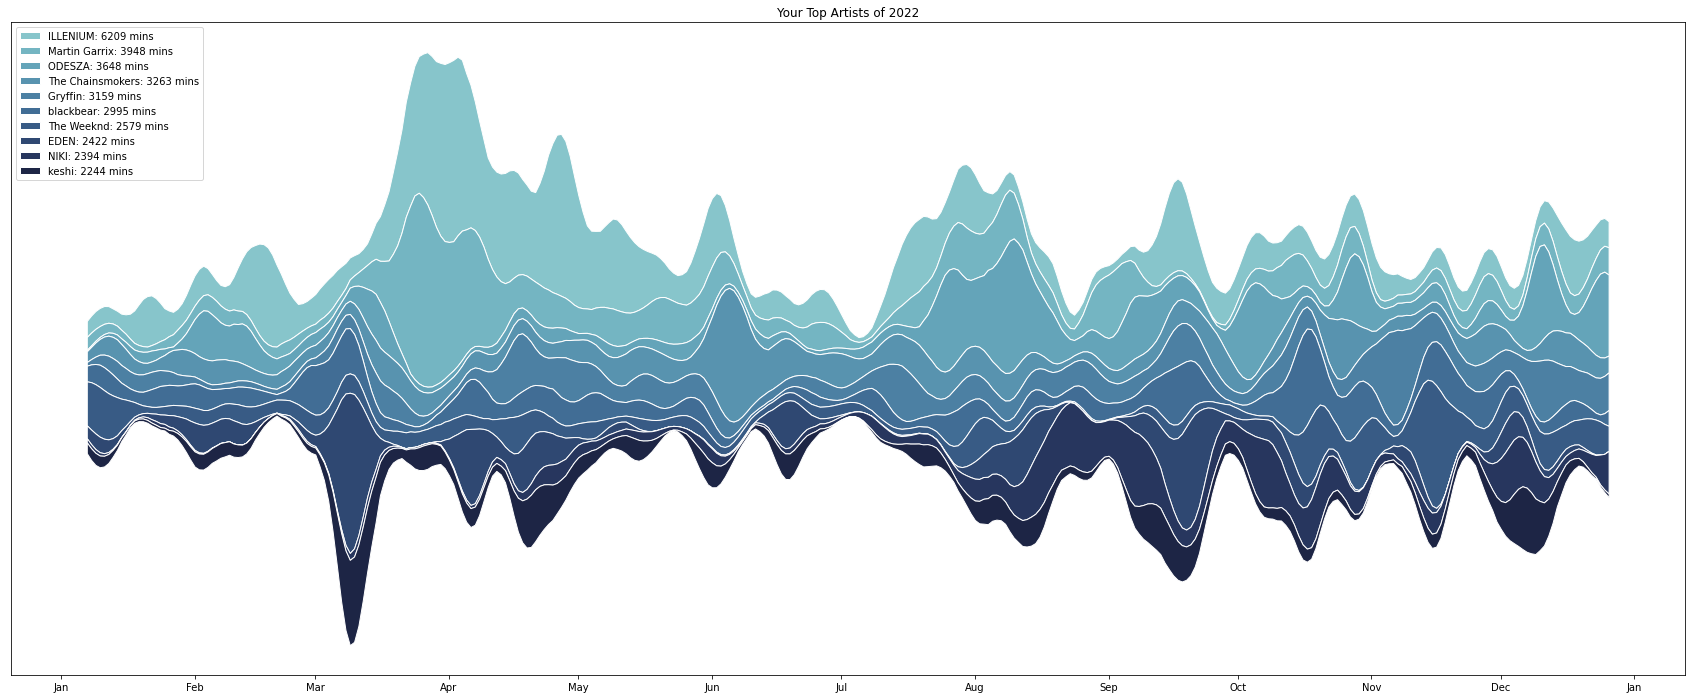

In [5]:
from utils import streamgraph

y_labels  = [f'{top_artists[i]}: {round(artist_totals[i])} mins' for i in range(len(top_artists))]
artist_daily_avgmins = [top_artists_df.loc[top_artists_df['artistName']==artist, 'avg_minsPlayed'] for artist in top_artists]
streamgraph(dates = all_dates['date'].values, ys=artist_daily_avgmins, labels = y_labels, title='Your Top Artists of 2022')

/Users/jyin/spotify-analysis/utils.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontweight='bold', color=pal[num_factors-1])


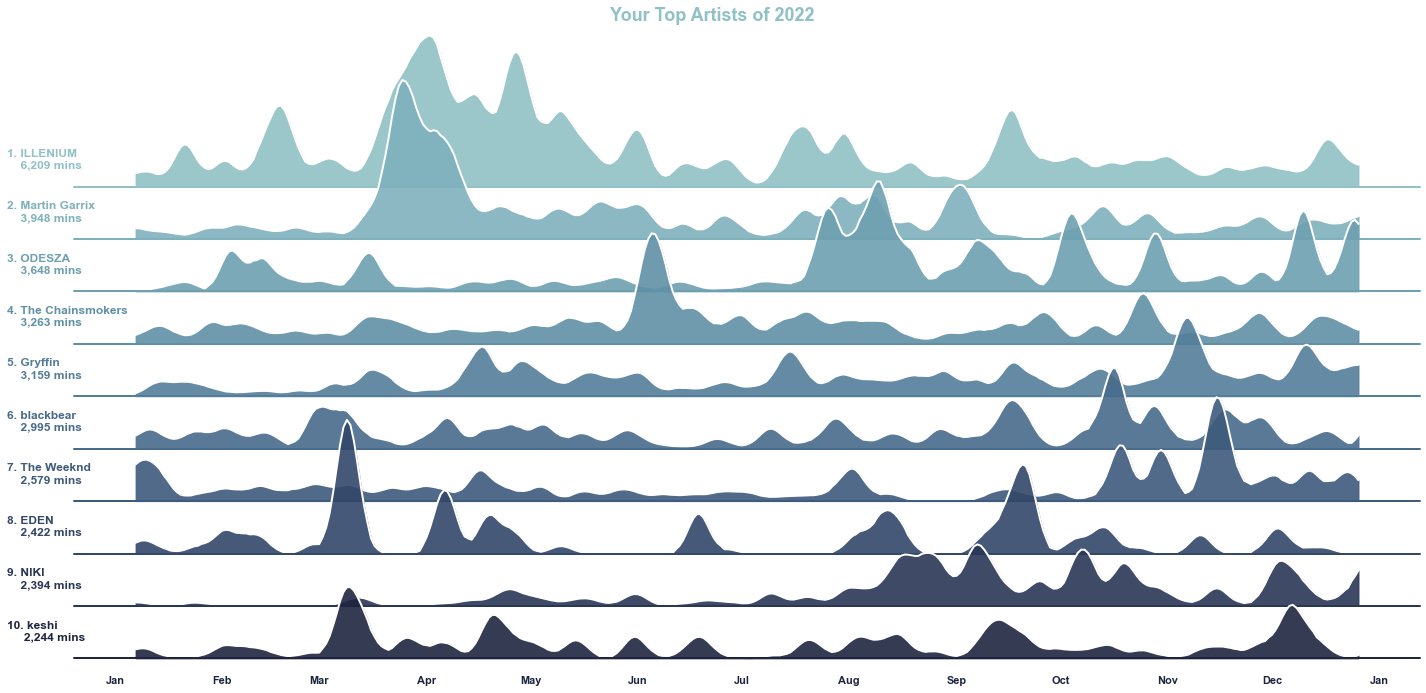

In [6]:
from utils import timeseries_ridgeplot

y_labels = {top_artists[i]: f"{i+1}. {top_artists[i]}\n" + " "*(3+len(str(i+1)))+ f"{round(artist_totals[top_artists[i]]):,} mins" for i in range(len(top_artists))}

timeseries_ridgeplot(top_artists_df, factor='artistName', y='avg_minsPlayed', dateCol = 'date', title='Your Top Artists of 2022', save_name='top_artists.png', labels=y_labels)